/opt/anaconda3/lib/python3.12/site-packages/mapclassify/classifiers.py:1760: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


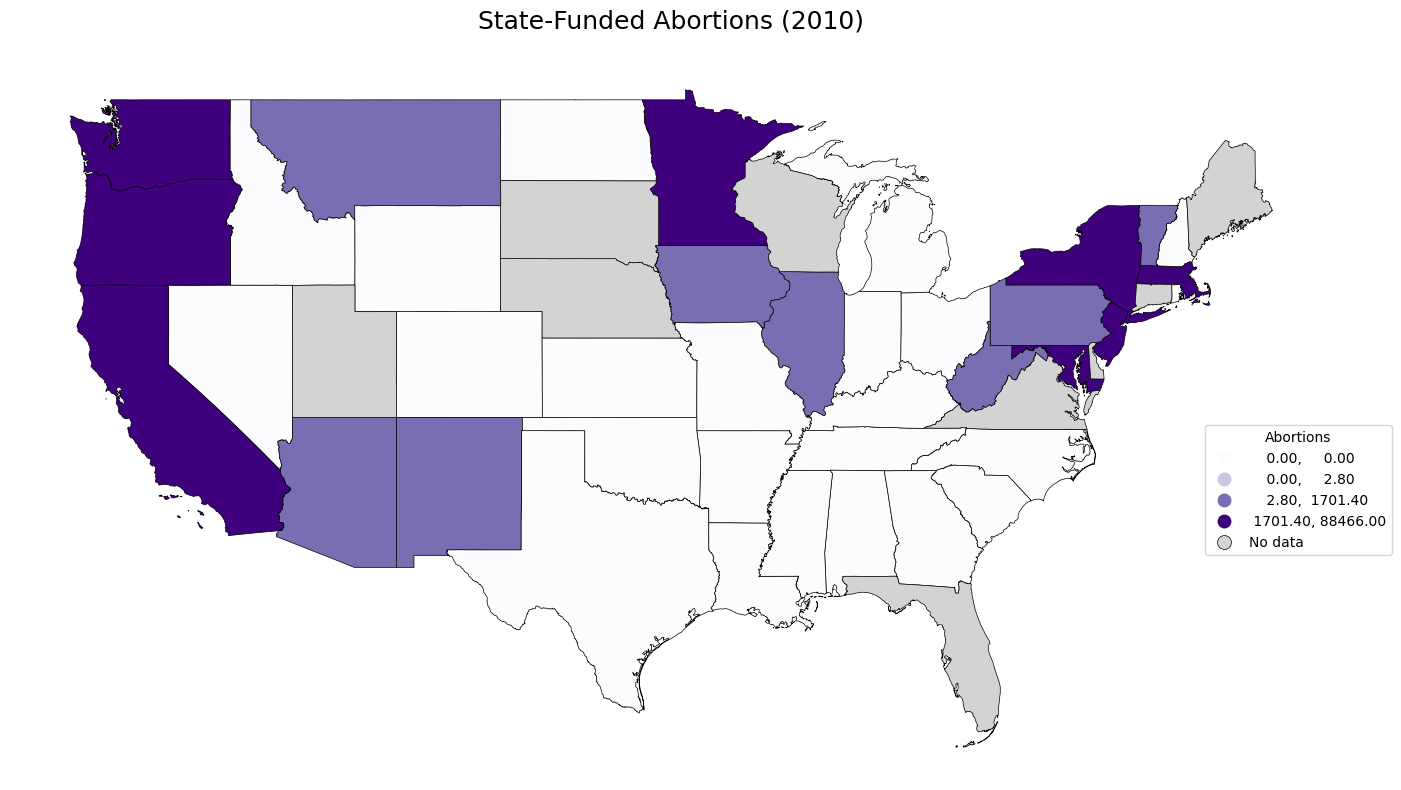

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load your cleaned dataset
raw = pd.read_csv("data/abortion_data.csv")

# 1.2 rename/clean
abortion_df = raw.rename(columns={
    'U.S. State': 'state',
    '% change in abortion rate, 2017-2020': 'pct_change_abortion_rate_17_20',
    '% change in the no. of abortion clinics, 2017-2020': 'pct_change_clinics_17_20',
    '% change in the no. of abortion providers, 2014-2017': 'pct_change_providers_14_17',
    '% of all U.S. abortions, by state of occurrence, 2020': 'pct_us_abortions_2020',
    '% of counties without a known abortion provider, 2014': 'pct_counties_no_provider_2014',
    '% of counties without a known clinic, 2020': 'pct_counties_no_clinic_2020',
    '% of residents obtaining abortions who traveled out of state for care, 2020': 'pct_traveled_out_2020',
    '% of women aged 15-44 living in a county without a clinic, 2020': 'pct_women_no_clinic_2020',
    '% of women aged 15-44 living in a county without an abortion provider, 2014': 'pct_women_no_provider_2014',
    'Abortion rate (the no. of abortions per 1,000 women aged 15-17), by state of residence, 2017': 'rate_15_17_per_1k_2017',
    'Abortion rate (the no. of abortions per 1,000 women aged 15-19), by state of residence, 2017': 'rate_15_19_per_1k_2017',
    'Abortion rate (the no. of abortions per 1,000 women aged 18-19), by state of residence, 2017': 'rate_18_19_per_1k_2017',
    'Change in the no. of abortion clinics, 2017-2020': 'change_clinics_17_20',
    'Change in the no. of abortion providers, 2014-2017': 'change_providers_14_17',
    'No. of abortion clinics, 2020': 'num_clinics_2020',
    'No. of abortion providers, 2017': 'num_providers_2017',
    'No. of abortions among women aged 15-17, by state of residence, 2017': 'abortions_15_17_2017',
    'No. of abortions among women aged 15-19, by state of residence, 2017': 'abortions_15_19_2017',
    'No. of abortions among women aged 18-19, by state of residence, 2017': 'abortions_18_19_2017',
    'No. of abortions among women younger than 15, by state of residence, 2017': 'abortions_under_15_2017',
    'No. of abortions per 1,000 women aged 15–44, by state of occurrence, 2020': 'rate_per_1k_occurrence_2020',
    'No. of abortions per 1,000 women aged 15–44, by state of residence, 2020': 'rate_per_1k_residence_2020',
    'No. of abortions, by state of occurrence, 2020': 'abortions_occurrence_2020',
    'No. of abortions, by state of residence, 2020': 'abortions_residence_2020',
    'No. of federally funded abortions, 2010': 'fed_funded_abortions_2010',
    'No. of state funded abortions, 2010': 'state_funded_abortions_2010',
    'Reported public expenditures for abortions (in 000s of dollars), federal, 2015': 'fed_expenditures_000s_2015',
    'Reported public expenditures for abortions (in 000s of dollars), state, 2015': 'state_expenditures_000s_2015',
    'Total no. of publicly funded abortions , 2010': 'total_pub_funded_abortions_2010',
    'Total reported public expenditures for abortions (in 000s of dollars), 2015': 'total_expenditures_000s_2015'
})


# 2. Load U.S. state geometries
gdf = gpd.read_file(
    "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json"
)[['NAME', 'geometry']].rename(columns={'NAME': 'state'})

# 2.1 Normalize state names to match
abortion_df['state'] = abortion_df['state'].str.strip()
gdf['state'] = gdf['state'].str.strip()

# 2.2 Optional: drop Puerto Rico early
gdf = gdf[~gdf['state'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# 3. Merge datasets
merged = gdf.merge(abortion_df, on='state', how='left')

# 4. Clean target column
merged['state_funded_abortions_2010'] = pd.to_numeric(
    merged['state_funded_abortions_2010']
    .astype(str)
    .str.replace(',', '', regex=False),
    errors='coerce'
)

# 5. Plot
fig, ax = plt.subplots(figsize=(14, 8))
merged.plot(
    column='state_funded_abortions_2010',
    cmap='Purples',
    scheme='quantiles',
    k=5,
    legend=True,
    edgecolor='black',     # black outlines
    linewidth=0.5,
    missing_kwds={"color": "lightgrey", "label": "No data"},
    ax=ax
)

ax.set_title("State-Funded Abortions (2010)", fontsize=18, pad=20)
ax.axis('off')
ax.set_aspect('auto')

# Adjust legend position
leg = ax.get_legend()
if leg:
    leg.set_bbox_to_anchor((1.05, 0.5))
    leg.set_title("Abortions", prop={'size': 10})

plt.tight_layout()
plt.show()


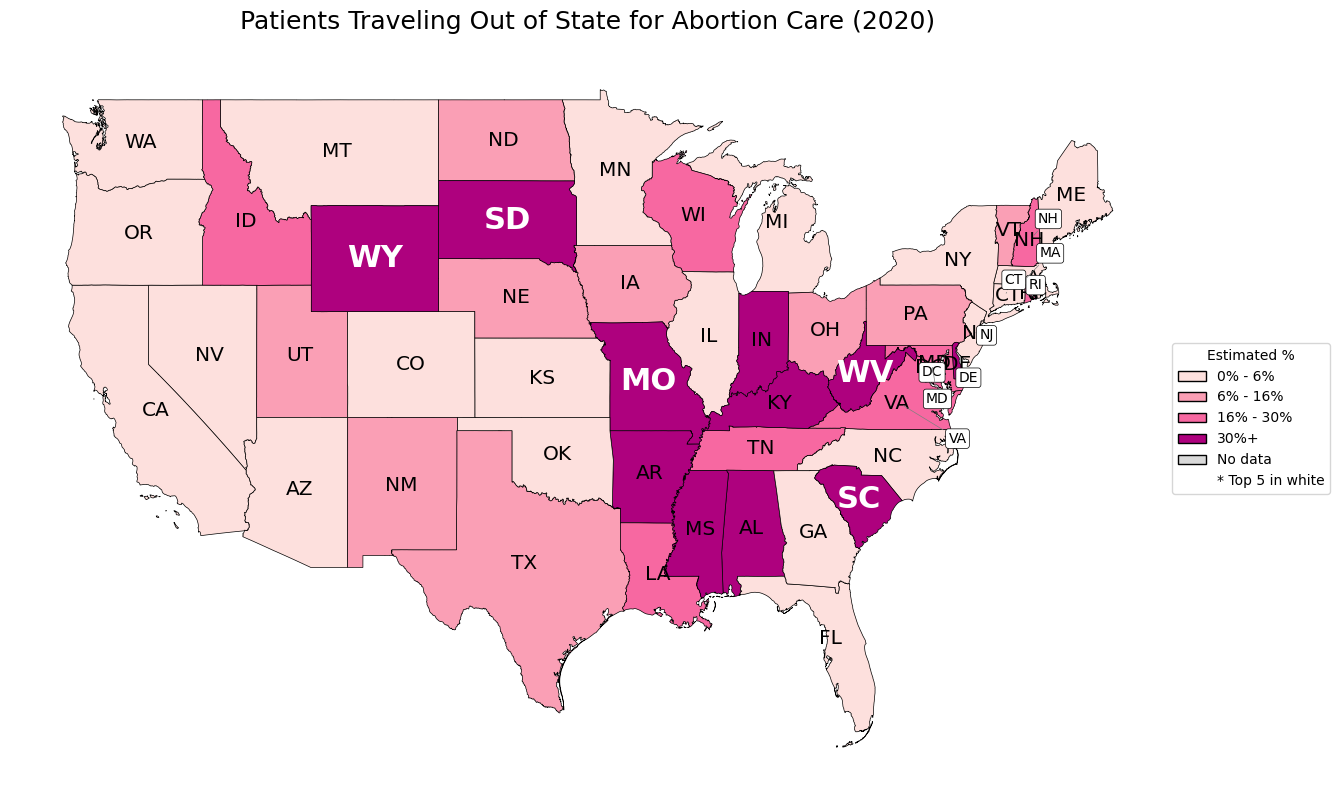

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# --- 1. Clean column ---
merged['pct_traveled_out_2020'] = pd.to_numeric(
    merged['pct_traveled_out_2020']
    .astype(str)
    .str.replace('%', '', regex=False)
    .str.replace(',', '', regex=False),
    errors='coerce'
).round(0)

# --- 2. Define 4 bins and labels ---
bin_edges = [0, 6, 16, 30, 100]
bin_labels = ['0% - 6%', '6% - 16%', '16% - 30%', '30%+']
pink_colors = ['#fde0dd', '#fa9fb5', '#f768a1', '#ae017e']  # light → dark pink

# --- 3. Cut and assign colors ---
merged['travel_bin'] = pd.cut(
    merged['pct_traveled_out_2020'],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)
color_map = dict(zip(bin_labels, pink_colors))
merged['color'] = merged['travel_bin'].map(color_map).astype(str).replace('nan', '#d9d9d9')  # gray for no data

# --- 4. Plot map ---
fig, ax = plt.subplots(figsize=(13.5, 8))
merged.plot(
    color=merged['color'],
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)

# --- 5. Add state abbreviations ---
state_abbr = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN',
    'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI',
    'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
    'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}
merged['abbr'] = merged['state'].map(state_abbr)

# Highlight top 5
top5 = merged.nlargest(5, 'pct_traveled_out_2020')
for idx, row in merged.iterrows():
    if pd.isna(row['abbr']) or row['geometry'].is_empty:
        continue
    centroid = row['geometry'].centroid
    label = row['abbr']
    if row['state'] in top5['state'].values:
        ax.text(centroid.x, centroid.y, label, fontsize=22, fontweight='bold', ha='center', va='center', color='white')
    else:
        ax.text(centroid.x, centroid.y, label, fontsize=14.5, ha='center', va='center', color='black')

# --- 6. Legend (updated for 4 bins + no data + top 5 note) ---
# 1. Main patches for actual data bins
legend_patches = [Patch(facecolor=color_map[label], edgecolor='black', label=label) for label in bin_labels]
legend_patches.append(Patch(facecolor='#d9d9d9', edgecolor='black', label='No data'))

# 2. Add an invisible handle with just a text label (the note)
legend_patches.append(Line2D([0], [0], color='none', label='* Top 5 in white'))

# 3. Show legend
ax.legend(
    handles=legend_patches,
    title="Estimated %",
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=True
)

# --- 6b. Manual annotation for crowded northeastern states ---
external_labels = {
    'DC':  (-76.9, 38.7, -77.1, 38.9),
    'DE':  (-74.9, 38.5, -75.5, 38.9),
    'MD':  (-76.6, 37.7, -76.9, 39.0),
    'NJ':  (-73.9, 40.1, -74.5, 40.2),
    'CT':  (-72.4, 42.2, -72.9, 41.6),
    'RI':  (-71.2, 42.0, -71.6, 41.6),
    'MA':  (-70.4, 43.2, -71.8, 42.2),
    'NH':  (-70.5, 44.5, -71.4, 43.8),
    'VA':  (-75.5, 36.2, -78.6, 37.5)
}

for abbr, (x_text, y_text, x_arrow, y_arrow) in external_labels.items():
    ax.annotate(
        abbr,
        xy=(x_arrow, y_arrow),  # point on the map
        xytext=(x_text, y_text),  # text location
        textcoords='data',
        ha='center', va='center',
        fontsize=10,
        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='black', lw=0.5),
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
    )


# --- 7. Final formatting ---
ax.set_title("Patients Traveling Out of State for Abortion Care (2020)", fontsize=18, pad=20)
ax.axis('off')
ax.set_aspect('auto')
plt.tight_layout()

# Save as high-res PNG
#plt.savefig("final_viz/out_of_state_abortions_2020.png", dpi=300, bbox_inches='tight')

# Then show it
plt.show()


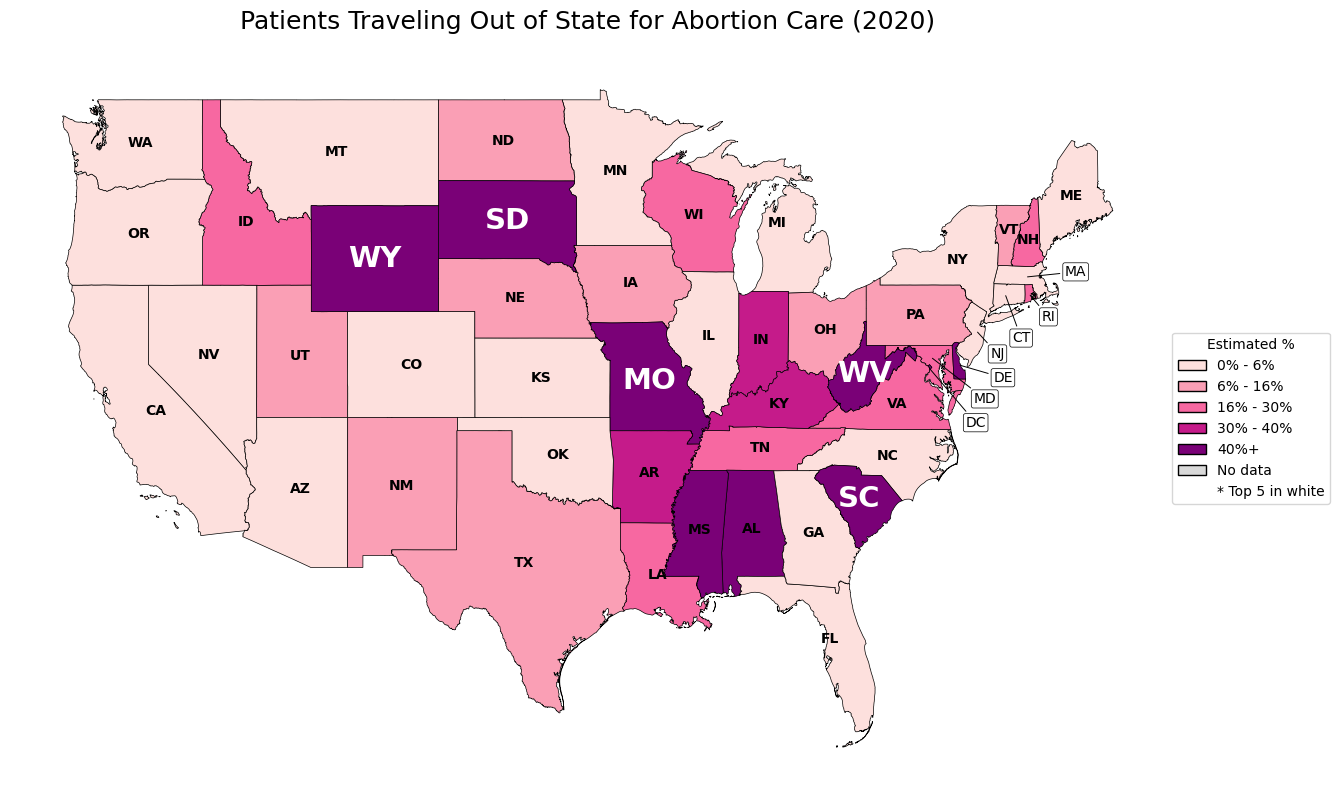

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# --- 1. Clean column ---
merged['pct_traveled_out_2020'] = pd.to_numeric(
    merged['pct_traveled_out_2020']
    .astype(str)
    .str.replace('%', '', regex=False)
    .str.replace(',', '', regex=False),
    errors='coerce'
).round(0)

# --- 2. Define 4 bins and labels ---
bin_edges = [0, 6, 16, 30, 40, 100]
bin_labels = ['0% - 6%', '6% - 16%', '16% - 30%', '30% - 40%', '40%+']
pink_colors = ['#fde0dd', '#fa9fb5', '#f768a1', '#c51b8a', '#7a0177']  # new darker pink added

# --- 3. Cut and assign colors ---
merged['travel_bin'] = pd.cut(
    merged['pct_traveled_out_2020'],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)
color_map = dict(zip(bin_labels, pink_colors))
merged['color'] = merged['travel_bin'].map(color_map).astype(str).replace('nan', '#d9d9d9')  # gray for no data

# --- 4. Plot map ---
fig, ax = plt.subplots(figsize=(13.5, 8))
merged.plot(
    color=merged['color'],
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)

# --- 5. Add state abbreviations ---
state_abbr = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN',
    'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI',
    'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
    'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}
merged['abbr'] = merged['state'].map(state_abbr)

crowded_states = set(['DC', 'DE', 'MD', 'NJ', 'CT', 'RI', 'MA'])

for idx, row in merged.iterrows():
    abbr = row['abbr']
    if pd.isna(abbr) or row['geometry'].is_empty or abbr in crowded_states:
        continue

    centroid = row['geometry'].centroid
    color = 'white' if row['state'] in top5['state'].values else 'black'
    size = 21 if row['state'] in top5['state'].values else 10

    ax.text(
        centroid.x, centroid.y,
        abbr,
        fontsize=size,
        fontweight='bold',
        ha='center', va='center',
        color=color
    )

# --- 6. Legend (updated for 4 bins + no data + top 5 note) ---
# 1. Main patches for actual data bins
legend_patches = [Patch(facecolor=color_map[label], edgecolor='black', label=label) for label in bin_labels]
legend_patches.append(Patch(facecolor='#d9d9d9', edgecolor='black', label='No data'))

# 2. Add an invisible handle with just a text label (the note)
legend_patches.append(Line2D([0], [0], color='none', label='* Top 5 in white'))

# 3. Show legend
ax.legend(
    handles=legend_patches,
    title="Estimated %",
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=True
)

# --- 6b. Manual annotation for crowded northeastern states ---
external_labels = {
    'DC':  (-74.5, 36.8, -77.1, 38.9),
    'MD':  (-74, 37.7, -77, 39.3),
    'DE':  (-73, 38.5, -75.5, 39.0),
    'NJ':  (-73.3, 39.4, -74.5, 40.3),
    'CT':  (-72, 40, -72.9, 41.7),
    'RI':  (-70.5, 40.8, -71.6, 41.7),
    'MA':  (-69, 42.5, -71.8, 42.3)
}

for abbr, (x_text, y_text, x_arrow, y_arrow) in external_labels.items():
    ax.annotate(
        abbr,
        xy=(x_arrow, y_arrow),        # point on the state
        xytext=(x_text, y_text),      # where to put the label
        textcoords='data',
        ha='center', va='center',
        fontsize=10,
        bbox=dict(boxstyle='round,pad=0.15', fc='white', ec='black', lw=0.5),
        arrowprops=dict(arrowstyle='-', color='black', lw=0.7)
    )


# --- 7. Final formatting ---
ax.set_title("Patients Traveling Out of State for Abortion Care (2020)", fontsize=18, pad=20)
ax.axis('off')
ax.set_aspect('auto')
plt.tight_layout()

# Save as high-res PNG
plt.savefig("final_viz/out_of_state_abortions_2020.png", dpi=300, bbox_inches='tight')

# Then show it
plt.show()


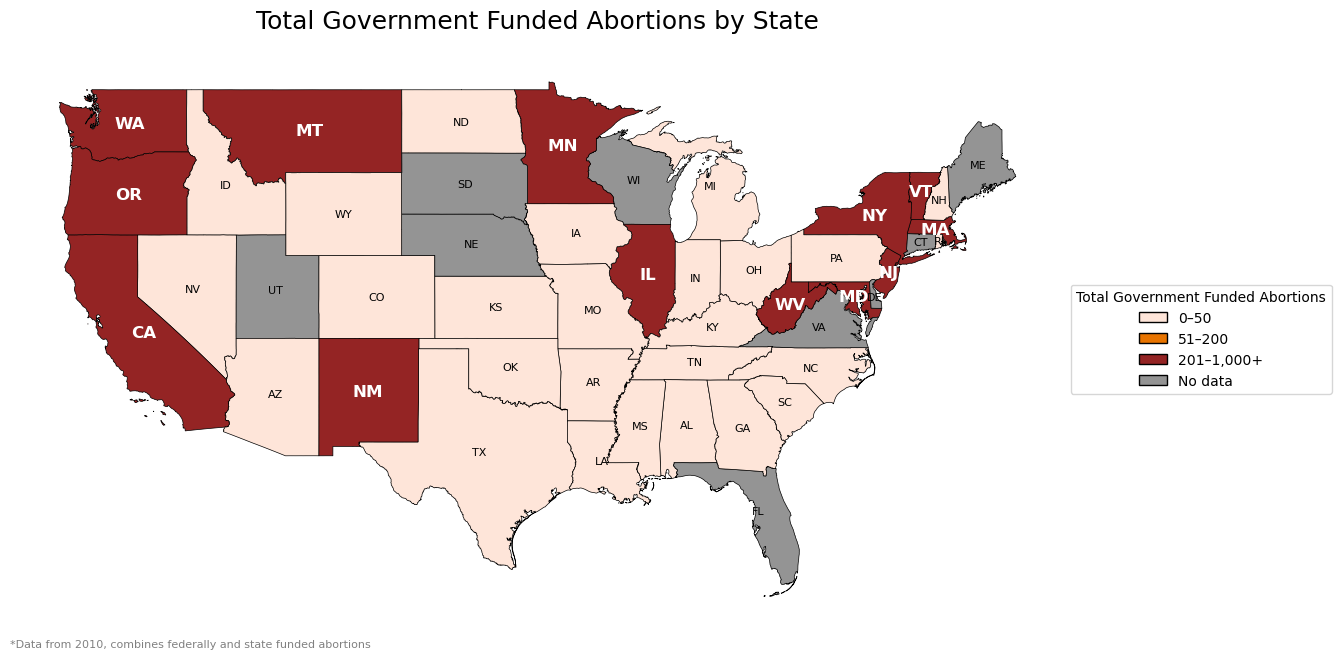

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- 1. Combine both columns into total funded abortions ---
merged['total_funded_abortions_2010'] = (
    pd.to_numeric(merged['fed_funded_abortions_2010'].astype(str).str.replace(',', ''), errors='coerce') +
    pd.to_numeric(merged['state_funded_abortions_2010'].astype(str).str.replace(',', ''), errors='coerce')
)

# --- 2. Define custom bins and labels ---
def categorize_total(val):
    if pd.isna(val):
        return 'No data'
    elif val <= 50:
        return '0–50'
    elif val <= 200:
        return '51–200'
    else:
        return '201–1,000+'

merged['funded_bin'] = merged['total_funded_abortions_2010'].apply(categorize_total)

# --- 3. Assign custom colors ---
bin_colors = {
    '0–50': '#fee5d9',        # very light red
    '51–200': "#e87400",      # medium red-orange
    '201–1,000+': "#942424",  # deep red
    'No data': "#949494ff"    # grey
}
merged['color'] = merged['funded_bin'].map(bin_colors)

# --- 4. Add state abbreviations ---
state_abbr = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}
merged['abbr'] = merged['state'].map(state_abbr)

# --- 5. Plot ---
fig, ax = plt.subplots(figsize=(13.5, 8))
merged.plot(
    color=merged['color'],
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)

# --- 6. Add state labels ---
for idx, row in merged.iterrows():
    if pd.notna(row['abbr']) and not row['geometry'].is_empty:
        centroid = row['geometry'].centroid
        # Customize for high-abortion states
        if row['funded_bin'] == '201–1,000+':
            ax.text(
                centroid.x, centroid.y, row['abbr'],
                fontsize=12, fontweight='bold', color='white',
                ha='center', va='center'
            )
        else:
            ax.text(
                centroid.x, centroid.y, row['abbr'],
                fontsize=8, color='black',
                ha='center', va='center'
            )

# --- 7. Legend ---
legend_elements = [Patch(facecolor=color, edgecolor='black', label=label) for label, color in bin_colors.items()]
ax.legend(
    handles=legend_elements,
    title="Total Government Funded Abortions",
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

# --- 8. Final formatting ---
ax.set_title("Total Government Funded Abortions by State", fontsize=18, pad=20)
ax.axis('off')

# --- 9. Subtle source annotation ---
fig.text(
    0.01, 0.1,
    "*Data from 2010, combines federally and state funded abortions",
    fontsize=8,
    color='gray',
    ha='left',
    va='bottom'
)

plt.tight_layout()

# Save as high-res PNG
plt.savefig("final_viz/total_government_funded_abortions_by_state_2010.png", dpi=300, bbox_inches='tight')

# Then show it
plt.show()
